# library

In [1]:
import os

if not os.path.exists('dataset1'):

    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 115.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 109.3 MB/s eta

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# dataset

In [3]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229,0.224,0.225]) #ImageNet
])

In [4]:
class SegData(Dataset):

    def __init__(self, split):

        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split

    def __len__(self):

        return len(self.items)

    def __getitem__(self, ix):

        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))

        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224,224))

        return image, mask

    def choose(self):

        return self[randint(len(self))]

    def collate_fn(self, batch):

        ims, masks = list(zip(*batch))

        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)

        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)

        return ims, ce_masks

In [5]:
trn_ds = SegData('train')
val_ds = SegData('test')

trn_dl = DataLoader(trn_ds, batch_size = 4, shuffle = True, collate_fn = trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size = 1, shuffle = False, collate_fn = val_ds.collate_fn)

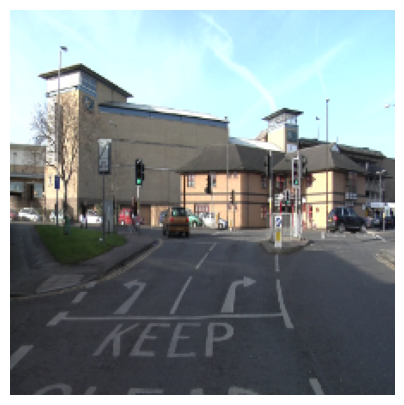

In [6]:
show(trn_ds[10][0])

# model

https://pasus.tistory.com/204

In [7]:
def conv(in_channels, out_channels):

    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [8]:
def up_conv(in_channels, out_channels):

    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2),
        nn.ReLU(inplace = True)
    )

In [9]:
from torchvision.models import vgg16_bn

class UNet(nn.Module):

    def __init__(self, weights = 'DEFAULT', out_channels = 12):

        super().__init__()

        self.encoder = vgg16_bn(weights = weights).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512,1024)

        self.up_conv6 = up_conv(1024,512)
        self.conv6 = conv(512 + 512, 512)

        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)

        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)

        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)

        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)

        self.conv11 = nn.Conv2d(32, out_channels, kernel_size = 1)

    def forward(self, x):

        #contracting path(encoding, conv + batch + relu + conv + batch + relu + max_pool)
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        #bridge
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        #extracting(up_conv + skip connection + conv)
        x = self.up_conv6(x)
        x = torch.cat([x,block5], dim = 1) #contracting path skip connection
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x,block4],dim = 1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x,block3], dim = 1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x,block2], dim = 1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x,block1], dim = 1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [10]:
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):

    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()

    return ce_loss, acc

In [11]:
model = UNet().to(device)

criterion = UnetLoss

optimizer = optim.Adam(model.parameters(), lr = 1e-3)

n_epochs = 20

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 87.0MB/s]


# train

In [12]:
def train_batch(model, data, optimizer, criterion):

    model.train()

    ims, ce_masks = data

    _masks = model(ims)

    optimizer.zero_grad()

    loss, acc = criterion(_masks, ce_masks)

    loss.backward()

    optimizer.step()

    return loss.item(), acc.item()

In [13]:
@torch.no_grad()
def validate_batch(model, data, criterion):

    model.eval()

    ims, masks = data

    _masks = model(ims)

    loss, acc = criterion(_masks, masks)

    return loss.item(), acc.item()

In [15]:
len(trn_dl)

92

In [17]:
log = Report(n_epochs)

for ex in range(n_epochs):

    N = len(trn_dl)

    for bx, data in enumerate(trn_dl):

        loss, acc = train_batch(model, data, optimizer, criterion)

        try:

            log.record(ex + (bx+1)//N, trn_loss = loss, trn_acc = acc, end = '\r')

        except:

            continue

    N = len(val_dl)

    for bx, data in enumerate(val_dl):

        loss, acc = validate_batch(model, data, criterion)

        try:

            log.record(ex + (bx+1)//N, val_loss = loss, val_acc = acc, end = '\r')

        except:

            continue

    log.report_avgs(ex+1)

EPOCH: 1.000  val_loss: 0.973  val_acc: 0.778  trn_loss: 1.188  trn_acc: 0.757  (18.17s - 345.31s remaining)
EPOCH: 2.000  val_loss: 0.552  val_acc: 0.859  trn_loss: 0.685  trn_acc: 0.832  (36.96s - 332.63s remaining)
EPOCH: 3.000  val_loss: 0.557  val_acc: 0.864  trn_loss: 0.590  trn_acc: 0.843  (55.17s - 312.63s remaining)
EPOCH: 4.000  val_loss: 0.559  val_acc: 0.849  trn_loss: 0.509  trn_acc: 0.863  (73.78s - 295.14s remaining)
EPOCH: 5.000  val_loss: 0.797  val_acc: 0.782  trn_loss: 0.471  trn_acc: 0.872  (92.43s - 277.29s remaining)
EPOCH: 6.000  val_loss: 1.254  val_acc: 0.662  trn_loss: 0.466  trn_acc: 0.870  (110.70s - 258.30s remaining)
EPOCH: 7.000  val_loss: 0.490  val_acc: 0.859  trn_loss: 0.461  trn_acc: 0.870  (129.26s - 240.05s remaining)
EPOCH: 8.000  val_loss: 0.455  val_acc: 0.867  trn_loss: 0.399  trn_acc: 0.887  (147.56s - 221.34s remaining)
EPOCH: 9.000  val_loss: 0.411  val_acc: 0.878  trn_loss: 0.369  trn_acc: 0.894  (166.07s - 202.98s remaining)
EPOCH: 10.000  

100%|██████████| 121/121 [00:00<00:00, 1631.97it/s]


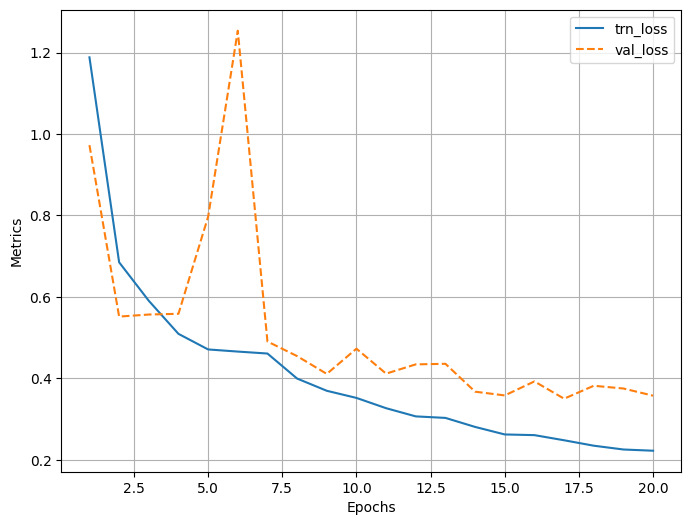

In [18]:
log.plot_epochs(['trn_loss', 'val_loss'])

# test

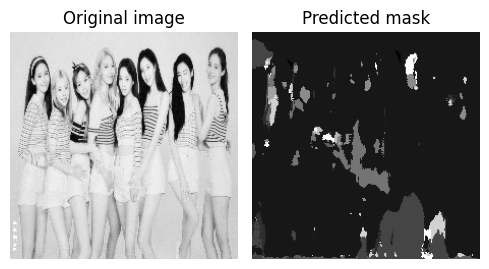

In [28]:

image = read('/content/gg.jpg', 1)

image = cv2.resize(image, (224,224))

im = torch.cat([tfms(image.copy()/255.)[None]]).float().to(device)

_mask = model(im)

_, _mask = torch.max(_mask, dim = 1)

subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], _mask.permute(1,2,0).detach().cpu()[:,:,0]],nc=2,titles=['Original image', 'Predicted mask'])


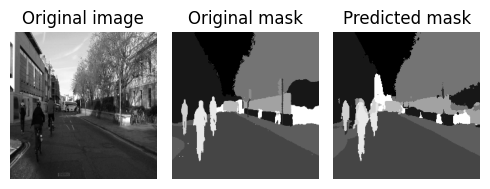

In [29]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])